In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.stats import norm
import pandas as pd
from enum import IntEnum
import unittest

# Q1 - Trinomial Tree Methods for European Options

In [2]:
class CallPutType(IntEnum):
    Call = 0
    Put = 1
    
class EuroAmerType(IntEnum):
    EuropeanOption = 0
    AmericanOption = 1
    
def generate_geometric_sequence(start, ratio, length):
    """
    e.g. start = 10, ratio = 2, length = 5
    return [10, 20, 40, 80, 160]
    """
    progression = np.empty(length, dtype=int)
    for i in range(0, length):
        curr_term = start * pow(ratio, i)
        progression[i] = int(curr_term)
    return progression

In [3]:
def d1(S, K, T, r, q, sigma):
    """Calculates d1 (BSM)."""
    return (math.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * math.sqrt(T))

def d2(S, K, T, r, q, sigma, d1_val=None):
    """Calculates d2 (BSM)."""
    if d1_val is None:
        d1_val = d1(S, K, T, r, q, sigma)
    return d1_val - sigma * math.sqrt(T)

def bs_call(S, K, T, r, q, sigma):
    """Calculate the value for a European call option (BSM)."""
    d1_val = d1(S, K, T, r, q, sigma)
    d2_val = d2(S, K, T, r, q, sigma, d1_val)
    return S * math.exp(-q * T) * norm.cdf(d1_val) - K * math.exp(-r * T) * norm.cdf(d2_val)

def bs_put(S, K, T, r, q, sigma):
    """Calculate the value for a European put option (BSM)."""
    d1_val = d1(S, K, T, r, q, sigma)
    d2_val = d2(S, K, T, r, q, sigma, d1_val)
    return K * math.exp(-r * T) * norm.cdf(-d2_val) - S * math.exp(-q * T) * norm.cdf(-d1_val)

In [4]:
def payoffs(V, i, S_temp, K, flag1):
    if not flag1: # Call
        V[i] = max(S_temp - K, 0)
    else: # Put
        V[i] = max(K - S_temp, 0)

In [5]:
def trinomial_pricer(S0, K, T, r, q, sigma, N, flag1, flag2):
    ## Flag 1 --> 0 for call, 1 for put
    ## Flag 2 --> 0 for European, 1 for American
    
    ## Define parameters.
    dt = T/N ## Time step.
    u = np.exp(sigma*np.sqrt(3*dt))
    d = np.exp(-sigma*np.sqrt(3*dt))
    m = 1
    q_up = 1/6 + (r-q-sigma**2/2)*np.sqrt(dt/(12*sigma**2))
    q_down = 1/6 - (r-q-sigma**2/2)*np.sqrt(dt/(12*sigma**2))
    q_mid = 2/3
    disc = np.exp(-r*dt)
    discp = disc*q_up
    disc1p = disc*q_down
    discm = disc*q_mid
    
    V = np.empty(2*N + 1) 

    ## Calculate terminal payoffs.
    S_plus = S0
    S_minus = S0
    payoffs(V, N, S0, K, flag1)
    for i in range (1, N+1):
        S_plus *= u
        S_minus *= d
        payoffs(V, N-i, S_plus, K, flag1)
        payoffs(V, N+i, S_minus, K, flag1)
    
    ## Work backwards through the tree.
    if flag2: ## American Option.
        for j in range(N - 1, -1, -1):
    
            ## American put.
            if flag1:
                S_temp = S0 * u**j  # Start with the highest stock price for the timestep.
                early_exercise = False
                for k in range(2*j + 1):  # Loop from the top down.
                    EE_val = K - S_temp
                    if not early_exercise:
                        V[k] = discp * V[k] + discm * V[k+1] + disc1p * V[k+2]
                        if EE_val > V[k]:
                            V[k] = EE_val
                            early_exercise = True
                    else:
                        V[k] = EE_val
                    S_temp *= d
    
            ## American call.
            else:
                S_temp = S0 * d**j  # Start with the lowest stock price for the timestep.
    
                early_exercise = False
                for k in range(2*j, -1, -1):  # Loop from the bottom up.
                    EE_val = S_temp - K
                    if not early_exercise:
                        V[k] = discp * V[k] + discm * V[k+1] + disc1p * V[k+2]
                        if EE_val > V[k]:
                            V[k] = EE_val
                            early_exercise = True
                    else:
                        V[k] = EE_val      
                    S_temp *= u

    else: ## European Option.
        for j in range(N - 1, -1, -1):
            for k in range(2*j + 1):
                V[k] = discp * V[k] + discm * V[k+1] + disc1p * V[k+2]
    return V[0]

In [6]:
def trinomial_pricer_early_stop(S0, K, T, r, q, sigma, N, flag1, flag2, early_stop):
    ## Flag 1 --> 0 for call, 1 for put
    ## Flag 2 --> 0 for European, 1 for American
    
    ## Define parameters.
    dt = T/N ## Time step.
    u = np.exp(sigma*np.sqrt(3*dt))
    d = np.exp(-sigma*np.sqrt(3*dt))
    m = 1
    q_up = 1/6 + (r-q-sigma**2/2)*np.sqrt(dt/(12*sigma**2))
    q_down = 1/6 - (r-q-sigma**2/2)*np.sqrt(dt/(12*sigma**2))
    q_mid = 2/3
    disc = np.exp(-r*dt)
    discp = disc*q_up
    disc1p = disc*q_down
    discm = disc*q_mid
    
    V = np.empty(2*N + 1) 

    ## Calculate terminal payoffs.
    S_plus = S0
    S_minus = S0
    payoffs(V, N, S0, K, flag1)
    for i in range (1, N+1):
        S_plus *= u
        S_minus *= d
        payoffs(V, N-i, S_plus, K, flag1)
        payoffs(V, N+i, S_minus, K, flag1)
    
    ## Work backwards through the tree.
    if flag2: ## American Option.
        for j in range(N - 1, -1+early_stop, -1):
    
            ## American put.
            if flag1:
                S_temp = S0 * u**j  # Start with the highest stock price for the timestep.
                early_exercise = False
                for k in range(2*j + 1):  # Loop from the top down.
                    EE_val = K - S_temp
                    if not early_exercise:
                        V[k] = discp * V[k] + discm * V[k+1] + disc1p * V[k+2]
                        if EE_val > V[k]:
                            V[k] = EE_val
                            early_exercise = True
                    else:
                        V[k] = EE_val
                    S_temp *= d
    
            ## American call.
            else:
                S_temp = S0 * d**j  # Start with the lowest stock price for the timestep.
    
                early_exercise = False
                for k in range(2*j, -1, -1):  # Loop from the bottom up.
                    EE_val = S_temp - K
                    if not early_exercise:
                        V[k] = discp * V[k] + discm * V[k+1] + disc1p * V[k+2]
                        if EE_val > V[k]:
                            V[k] = EE_val
                            early_exercise = True
                    else:
                        V[k] = EE_val      
                    S_temp *= u

    else: ## European Option.
        for j in range(N - 1, -1+early_stop, -1):
            for k in range(2*j + 1):
                V[k] = discp * V[k] + discm * V[k+1] + disc1p * V[k+2]
    return V[:(2*early_stop+1)]

In [7]:
## Legacy code:
    # for j in range(N - 1, -1, -1):
    #     if flag2:
    #         S_temp = S0*u**j
    #     for k in range(2*j + 1):
    #         V[k] = discp * V[k] + discm * V[k+1] + disc1p * V[k+2]
            
    #         ## American Option Adjustment.
    #         if flag2: 
    #             if not flag1: ## American call.
    #                 V[k] = max(V[k], S_temp - K)
    #             else: ## American put.
    #                 V[k] = max(V[k], K - S_temp)
    #             S_temp *= d

In [8]:
def TBS_pricer(S0, K, T, r, q, sigma, N, flag1, flag2):
    ## Flag 1 --> 0 for call, 1 for put.
    ## Flag 2 --> 0 for European, 1 for American.
    
     ## Define parameters.
    dt = T/N ## Time step.
    u = np.exp(sigma*np.sqrt(3*dt))
    d = np.exp(-sigma*np.sqrt(3*dt))
    m = 1
    q_up = 1/6 + (r-q-sigma**2/2)*np.sqrt(dt/(12*sigma**2))
    q_down = 1/6 - (r-q-sigma**2/2)*np.sqrt(dt/(12*sigma**2))
    q_mid = 2/3
    disc = np.exp(-r*dt)
    discp = disc*q_up
    disc1p = disc*q_down
    discm = disc*q_mid
    
    V = np.empty(2*N) 

    ## Calculate terminal payoffs.
    S_plus = S0
    S_minus = S0
    if flag1: 
        V[N-1] = bs_put(S0, K, dt, r, q, sigma)
        for i in range (1, N):
            S_plus *= u
            S_minus *= d
            V[N-1-i] = bs_put(S_plus, K, dt, r, q, sigma)
            V[N-1+i] = bs_put(S_minus, K, dt, r, q, sigma)
    else:
        V[N-1] = bs_call(S0, K, dt, r, q, sigma)
        for i in range (1, N):
            S_plus *= u
            S_minus *= d
            V[N-1-i] = bs_call(S_plus, K, dt, r, q, sigma)
            V[N-1+i] = bs_call(S_minus, K, dt, r, q, sigma)
            
    ## Work backwards through the tree.
    if flag2: ## American Option.
        for j in range(N - 2, -1, -1):
    
            ## American put.
            if flag1:
                S_temp = S0 * u**j  # Start with the highest stock price for the timestep.
                early_exercise = False
                for k in range(2*j + 1):  # Loop from the top down.
                    EE_val = K - S_temp
                    if not early_exercise:
                        V[k] = discp * V[k] + discm * V[k+1] + disc1p * V[k+2]
                        if EE_val > V[k]:
                            V[k] = EE_val
                            early_exercise = True
                    else:
                        V[k] = EE_val
                    S_temp *= d
    
            ## American call.
            else:
                S_temp = S0 * d**j  # Start with the lowest stock price for the timestep.
    
                early_exercise = False
                for k in range(2*j, -1, -1):  # Loop from the bottom up.
                    EE_val = S_temp - K
                    if not early_exercise:
                        V[k] = discp * V[k] + discm * V[k+1] + disc1p * V[k+2]
                        if EE_val > V[k]:
                            V[k] = EE_val
                            early_exercise = True
                    else:
                        V[k] = EE_val      
                    S_temp *= u

    else: ## European Option.
        for j in range(N - 2, -1, -1):
            for k in range(2*j + 1):
                V[k] = discp * V[k] + discm * V[k+1] + disc1p * V[k+2]
                
    return V[0]

In [9]:
def TBS_pricer_early_stop(S0, K, T, r, q, sigma, N, flag1, flag2, early_stop):
    ## Flag 1 --> 0 for call, 1 for put.
    ## Flag 2 --> 0 for European, 1 for American.
    
    ## Define parameters.
    dt = T/N ## Time step.
    u = np.exp(sigma*np.sqrt(3*dt))
    d = np.exp(-sigma*np.sqrt(3*dt))
    m = 1
    q_up = 1/6 + (r-q-sigma**2/2)*np.sqrt(dt/(12*sigma**2))
    q_down = 1/6 - (r-q-sigma**2/2)*np.sqrt(dt/(12*sigma**2))
    q_mid = 2/3
    disc = np.exp(-r*dt)
    discp = disc*q_up
    disc1p = disc*q_down
    discm = disc*q_mid
    
    V = np.empty(2*N) 

    ## Calculate terminal payoffs.
    S_plus = S0
    S_minus = S0
    if flag1: 
        V[N-1] = bs_put(S0, K, dt, r, q, sigma)
        for i in range (1, N):
            S_plus *= u
            S_minus *= d
            V[N-1-i] = bs_put(S_plus, K, dt, r, q, sigma)
            V[N-1+i] = bs_put(S_minus, K, dt, r, q, sigma)
    else:
        V[N-1] = bs_call(S0, K, dt, r, q, sigma)
        for i in range (1, N):
            S_plus *= u
            S_minus *= d
            V[N-1-i] = bs_call(S_plus, K, dt, r, q, sigma)
            V[N-1+i] = bs_call(S_minus, K, dt, r, q, sigma)
            
    ## Work backwards through the tree.
    if flag2: ## American Option.
        for j in range(N - 2, -1+early_stop, -1):
    
            ## American put.
            if flag1:
                S_temp = S0 * u**j  # Start with the highest stock price for the timestep.
                early_exercise = False
                for k in range(2*j + 1):  # Loop from the top down.
                    EE_val = K - S_temp
                    if not early_exercise:
                        V[k] = discp * V[k] + discm * V[k+1] + disc1p * V[k+2]
                        if EE_val > V[k]:
                            V[k] = EE_val
                            early_exercise = True
                    else:
                        V[k] = EE_val
                    S_temp *= d
    
            ## American call.
            else:
                S_temp = S0 * d**j  # Start with the lowest stock price for the timestep.
    
                early_exercise = False
                for k in range(2*j, -1, -1):  # Loop from the bottom up.
                    EE_val = S_temp - K
                    if not early_exercise:
                        V[k] = discp * V[k] + discm * V[k+1] + disc1p * V[k+2]
                        if EE_val > V[k]:
                            V[k] = EE_val
                            early_exercise = True
                    else:
                        V[k] = EE_val      
                    S_temp *= u

    else: ## European Option.
        for j in range(N - 2, -1+early_stop, -1):
            for k in range(2*j + 1):
                V[k] = discp * V[k] + discm * V[k+1] + disc1p * V[k+2]
                
    return V[:(2*early_stop+1)]

In [10]:
## BS price at only nodes surrounding the option strike (future improvement):
    # for i in range(2*N + 1):
    #     S = S0*u**(N-i)
    #     if S <= u*K and S >= d*K:  # Surrounding the strike price K
    #         V[i] = bs_put(S, K, dt, r, q, sigma)
    #     else:
    #         payoffs(V, i, S, K, flag1)

In [11]:
def TBSR_pricer(S0, K, T, r, q, sigma, N, flag1, flag2):
    ## Flag 1 --> 0 for call, 1 for put.
    ## Flag 2 --> 0 for European, 1 for American.

    return (
        2*TBS_pricer(S0, K, T, r, q, sigma, N, flag1, flag2) 
        - TBS_pricer(S0, K, T, r, q, sigma, math.ceil(N//2), flag1, flag2)
    )


In [12]:
# Greeks
def delta_bs_european(S, K, T, r, q, sigma, call_put_type):
    d1_val = d1(S, K, T, r, q, sigma)
    if call_put_type == CallPutType.Call:
        delta = np.exp(-q*T) * norm.cdf(d1_val)
    elif call_put_type == CallPutType.Put:
        delta = -np.exp(-q*T) * norm.cdf(-d1_val)
    else:
        raise ValueError("invalid call_put_type")
    return delta

def delta_approx(V_1_0, V_1_2, S_1_0, S_1_2):
    return (V_1_0 - V_1_2) / (S_1_0 - S_1_2)

def gamma_bs_european(S, K, T, r, q, sigma, call_put_type):
    d1_val = d1(S, K, T, r, q, sigma)
    # gammas of C and P are the same for european options
    gamma = np.exp(-q*T) / (S*sigma*np.sqrt(T)) * (1/np.sqrt(2*np.pi)) * np.exp(-d1_val**2/2)
    return gamma

def gamma_approx(V_2_0, V_2_2, V_2_4, S_2_0, S_2_2, S_2_4):
    upper_1 = (V_2_0 - V_2_2) / (S_2_0 - S_2_2)
    upper_2 = (V_2_2 - V_2_4) / (S_2_2 - S_2_4)
    lower = (S_2_0 - S_2_4) / 2
    return (upper_1 - upper_2) / lower

def theta_bs_european(S, K, T, r, q, sigma, call_put_type):
    d1_val = d1(S, K, T, r, q, sigma)
    d2_val = d2(S, K, T, r, q, sigma)
    if call_put_type == CallPutType.Call:
        theta = (
            -(S*sigma*np.exp(-q*T)) / (2*np.sqrt(2*np.pi*T)) * np.exp(-d1_val**2/2)
            + q * S * np.exp(-q*T) * norm.cdf(d1_val)
            - r * K * np.exp(-r*T) * norm.cdf(d2_val)
        )
    elif call_put_type == CallPutType.Put:
        theta = (
            -(S*sigma*np.exp(-q*T)) / (2*np.sqrt(2*np.pi*T)) * np.exp(-d1_val**2/2) 
            - q * S * np.exp(-q*T) * norm.cdf(-d1_val) 
            + r * K * np.exp(-r*T) * norm.cdf(-d2_val)
        )
    else:
        raise ValueError("Invalid call_put_type")
    return theta

def theta_approx(V_1_1, V_0_0, T, N):
    dt = T/N
    return (V_1_1 - V_0_0) / dt


In [13]:
def u_(T, sigma, N):
    dt = T/N
    return np.exp(sigma*np.sqrt(3*dt))

def d_(T, sigma, N):
    return 1 / u_(T, sigma, N)

def approximation_error(reference, target):
    return abs(reference-target)

def approximation_error_true(reference, target):
    """
    keep the signal of the error, used in the variance reduction of American options
    """
    return reference-target

def linear_approximation_error(reference, target, N):
    return N * approximation_error(reference, target)

def quadratic_approximation_error(reference, target, N):
    return N**2 * approximation_error(reference, target)

In [14]:
class TestNotebook(unittest.TestCase):
    
    def test_generate_geometric_sequence(self):
        sequence = generate_geometric_sequence(10, 2, 5)
        assert np.array_equal(
            sequence, 
            [10, 20, 40, 80, 160]
        )
        
    def test_trinomial_pricer_early_stop(self):
        S0 = 41
        K = 39
        T = 1
        r = 0.03
        q = 0.005
        sigma = 0.25
        N = 100
        
        reference = trinomial_pricer_early_stop(S0, K, T, r, q, sigma, N, CallPutType.Put, EuroAmerType.EuropeanOption, early_stop=0)[0]
        target = trinomial_pricer(S0, K, T, r, q, sigma, N, CallPutType.Put, EuroAmerType.EuropeanOption)
        assert np.isclose(reference, target)
        
        reference = TBS_pricer_early_stop(
            S0, K, T, r, q, sigma, N, CallPutType.Put, EuroAmerType.EuropeanOption, 
            early_stop=0
        )[0]
        target = TBS_pricer(S0, K, T, r, q, sigma, N, CallPutType.Put, EuroAmerType.EuropeanOption)
        assert np.isclose(reference, target)
        
        reference = TBSR_pricer_early_stop(
            S0, K, T, r, q, sigma, N, CallPutType.Put, EuroAmerType.EuropeanOption, 
            early_stop=0
        )[0]
        target = TBSR_pricer(S0, K, T, r, q, sigma, N, CallPutType.Put, EuroAmerType.EuropeanOption)
        assert np.isclose(reference, target)
        
    def test_trinomial_pricer_early_stop_order(self):
        S0 = 41
        K = 39
        T = 1
        r = 0.03
        q = 0.005
        sigma = 0.25
        N = 100
        
        #early_stop=1
        values = trinomial_pricer_early_stop(
            S0, K, T, r, q, sigma, N, CallPutType.Put, EuroAmerType.EuropeanOption, 
            early_stop=1
        )
        assert len(values) == 3
        assert values[0] <= values[1] and values[1] <= values[2]
        
        # early_stop=2
        values = trinomial_pricer_early_stop(
            S0, K, T, r, q, sigma, N, CallPutType.Put, EuroAmerType.EuropeanOption, 
            early_stop=2
        )
        assert len(values) == 5
        assert values[0] <= values[1] and values[1] <= values[2]
        
    def test_u_d(self):
        T = 1
        sigma = 0.29
        N = 100
        u = u_(T, sigma, N)
        d = d_(T, sigma, N)
        assert np.isclose(u*d, 1.0)


unittest.main(argv=[''], verbosity=6, exit=False)

test_generate_geometric_sequence (__main__.TestNotebook) ... ok
test_trinomial_pricer_early_stop (__main__.TestNotebook) ... ERROR
test_trinomial_pricer_early_stop_order (__main__.TestNotebook) ... ok
test_u_d (__main__.TestNotebook) ... ok

ERROR: test_trinomial_pricer_early_stop (__main__.TestNotebook)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "C:\Users\17933\AppData\Local\Temp\ipykernel_23692\1862240403.py", line 30, in test_trinomial_pricer_early_stop
    reference = TBSR_pricer_early_stop(
NameError: name 'TBSR_pricer_early_stop' is not defined

----------------------------------------------------------------------
Ran 4 tests in 0.099s

FAILED (errors=1)


# Q2- Trinomial Tree Methods for American Options

In [23]:
def binomial_pricer(S0, K, T, r, q, sigma, N, flag1, flag2):
    ## Flag 1 --> 0 for call, 1 for put
    ## Flag 2 --> 0 for European, 1 for American
    
    ## Define parameters.
    dt = T/N ## Time step.
    u = np.exp(sigma*np.sqrt(dt))
    d = 1/u
    d_bar = d**2
    u_bar = u**2
    q_up = (np.exp((r-q)*dt) - d) / (u - d)
    q_down = 1 - q_up
    disc = np.exp(-r*dt)
    discp = disc*q_up
    disc1p = disc*q_down
    mid = N//2
    if not N % 2:
        S_temp1 = S0
    else:
        S_temp1 = S0*d
    S_temp2 = S_temp1*u_bar
    V = np.empty(N+1)

    ## Calculate terminal payoffs.      
    for i in range(mid,-1,-1):
        payoffs(V, i, S_temp1, K, flag1)
        S_temp1 *= d_bar
            
    for i in range(mid+1,N+1):
        payoffs(V, i, S_temp2, K, flag1)
        S_temp2 *= u_bar
            
    ## Work backwards through the tree.
    for j in range(N - 1, -1, -1):
        if flag2:
            S_temp = S0 * d**j
        for k in range(j + 1):
            V[k] = discp * V[k+1] + disc1p * V[k]
            
            ## American Option Adjustment.
            if flag2: 
                if not flag1: ## American call.
                    V[k] = max(V[k], S_temp - K)
                else: ## American put.
                    V[k] = max(V[k], K - S_temp)
                S_temp = S_temp * u_bar

    return V[0]

def binomial_delta_1(V_1_0, V_1_1, S_1_0, S_1_1):
    return (V_1_0 - V_1_1) / (S_1_0 - S_1_1)

def binomial_gamma_1(V_2_0, V_2_1, V_2_2, S_2_0, S_2_1, S_2_2):
    upper_1 = (V_2_0 - V_2_1) / (S_2_0 - S_2_1)
    upper_2 = (V_2_1 - V_2_2) / (S_2_1 - S_2_2)
    lower = (S_2_0 - S_2_2) / 2
    return (upper_1 - upper_2) / lower

def binomial_theta_1(V_2_1, V_0_0, T, N):
    dt = T/N
    return (V_2_1 - V_0_0) / (2*dt)

In [21]:
def binomial_pricer_early_stop(S0, K, T, r, q, sigma, N, flag1, flag2, early_stop):
    """
    This is a modication of Kevin's binomial pricer
    In order to get V_1_0, V_1_1, V_2_0, V_2_1, V_2_2, ...
    Args:
        early_stop: the nth step from V_0
    """
    ## Flag 1 --> 0 for call, 1 for put
    ## Flag 2 --> 0 for European, 1 for American
    
    ## Define parameters.
    dt = T/N ## Time step.
    u = np.exp(sigma*np.sqrt(dt))
    d = 1/u
    d_bar = d**2
    u_bar = u**2
    q_up = (np.exp((r-q)*dt) - d) / (u - d)
    q_down = 1 - q_up
    disc = np.exp(-r*dt)
    discp = disc*q_up
    disc1p = disc*q_down
    mid = N//2
    if not N % 2:
        S_temp1 = S0
    else:
        S_temp1 = S0*d
    S_temp2 = S_temp1*u_bar
    V = np.empty(N+1)

    ## Calculate terminal payoffs.
    for i in range(mid,-1,-1):
        payoffs(V, i, S_temp1, K, flag1, flag2)
        S_temp1 *= d_bar
            
    for i in range(mid+1,N+1):
        payoffs(V, i, S_temp2, K, flag1, flag2)
        S_temp2 *= u_bar
    
    ## Work backwards through the tree.
    for j in range(N - 1, -1+early_stop, -1):
        if flag2:
            S_temp = S0 * d**j
        for k in range(j + 1):
            V[k] = discp * V[k+1] + disc1p * V[k]
            
            ## American Option Adjustment.
            if flag2: 
                if not flag1: ## American call.
                    V[k] = max(V[k], S_temp - K)
                else: ## American put.
                    V[k] = max(V[k], K - S_temp)
                S_temp = S_temp * u_bar
    return V[:(early_stop+1)]

In [16]:
def avg_binomial_pricer(S0, K, T, r, q, sigma, N, flag1, flag2):
    ## Flag 1 --> 0 for call, 1 for put.
    ## Flag 2 --> 0 for European, 1 for American.

    return (binomial_pricer(S0, K, T, r, q, sigma, N, flag1, flag2) + binomial_pricer(S0, K, T, r, q, sigma, N-1, flag1, flag2))/2 ## Simple average.

### Exact value for European put

In [25]:
## Option Parameters. ##
S0 = 41
K = 39
T = 1
r = 0.03
q = 0.005
sigma = 0.25

bs_price = bs_put(S0, K, T, r, q, sigma)
Delta_BS = delta_bs_european(S0, K, T, r, q, sigma, CallPutType.Put) 
Gamma_BS = gamma_bs_european(S0, K, T, r, q, sigma, CallPutType.Put)
Theta_BS = theta_bs_european(S0, K, T, r, q, sigma, CallPutType.Put)

print("European option parameters:")
print("BS put price:", bs_price)
print("Delta_BS:", Delta_BS)
print("Gamma_BS:", Gamma_BS)
print("Theta_BS:", Theta_BS)

European option parameters:
BS put price: 2.6112395610760704
Delta_BS: -0.33373031448301743
Gamma_BS: 0.03538219842638576
Theta_BS: -1.4382603519087018


### Exact value for American put (results generated from the notebook of HW3)

In [25]:
# Appoximate the exact numbers of American put using the average of binomial trees at N=10000 and N=10001
S0 = 41
K = 39
T = 1
r = 0.03
q = 0.005
sigma = 0.25

N = [10000, 10001]
V_exact = 0
Delta_exact = 0
Gamma_exact = 0
Theta_exact = 0
for i in range(2):
    # preparation
    V_1_0, V_1_1 = binomial_pricer_early_stop(
        S0, K, T, r, q, sigma, N[i], CallPutType.Put, EuroAmerType.AmericanOption,
        early_stop=1
    )
    V_2_0, V_2_1, V_2_2 = binomial_pricer_early_stop(
        S0, K, T, r, q, sigma, N[i], CallPutType.Put, EuroAmerType.AmericanOption,
        early_stop=2
    )
    V_0_0 = binomial_pricer(S0, K, T, r, q, sigma, N[i], CallPutType.Put, EuroAmerType.AmericanOption)
    u = u_(T, sigma, N[i])
    d = d_(T, sigma, N[i])
    S_1_0 = S0 * u
    S_1_1 = S0 * d
    S_2_0 = S0 * u**2
    S_2_1 = S0 * u * d
    S_2_2 = S0 * d**2
    
    V_exact += 0.5 * binomial_pricer(S0, K, T, r, q, sigma, N[i], CallPutType.Put, EuroAmerType.AmericanOption)
    Delta_exact += 0.5 * delta_1(V_1_0, V_1_1, S_1_0, S_1_1)
    Gamma_exact += 0.5 * gamma_1(V_2_0, V_2_1, V_2_2, S_2_0, S_2_1, S_2_2)
    Theta_exact += 0.5 * theta_1(V_2_1, V_0_0, T, N[i])

print("American option parameters:")
print("V_Exact:", V_exact)
print("Delta_Exact:", Delta_exact)
print("Gamma_Exact:", Gamma_exact)
print("Theta_Exact:", Theta_exact)

American option parameters:
V_Exact: 2.677072919258733
Delta_Exact: 0.3453953479456865
Gamma_Exact: 0.020540847526719152
Theta_Exact: -1.5297714375291465


In [26]:
## Number of time steps to use.
N = np.array([10, 20, 40, 80, 160, 320, 640, 1280])

# Arrays for European Put Option Pricing
EP_TT = np.empty(len(N))
EP_TT_Diff = np.empty(len(N))
EP_TT_N_Diff = np.empty(len(N))
EP_TT_N2_Diff = np.empty(len(N))
EP_TT_delta_approx = np.empty(len(N))
EP_TT_delta_diff = np.empty(len(N))
EP_TT_gamma_approx = np.empty(len(N))
EP_TT_gamma_diff = np.empty(len(N))
EP_TT_theta_approx = np.empty(len(N))
EP_TT_theta_diff = np.empty(len(N))

EP_TBS = np.empty(len(N))
EP_TBS_Diff = np.empty(len(N))
EP_TBS_N_Diff = np.empty(len(N))
EP_TBS_N2_Diff = np.empty(len(N))
EP_TBS_delta_approx = np.empty(len(N))
EP_TBS_delta_diff = np.empty(len(N))
EP_TBS_gamma_approx = np.empty(len(N))
EP_TBS_gamma_diff = np.empty(len(N))
EP_TBS_theta_approx = np.empty(len(N))
EP_TBS_theta_diff = np.empty(len(N))

EP_TBSR = np.empty(len(N))
EP_TBSR_Diff = np.empty(len(N))
EP_TBSR_N_Diff = np.empty(len(N))
EP_TBSR_N2_Diff = np.empty(len(N))
EP_TBSR_delta_approx = np.empty(len(N))
EP_TBSR_delta_diff = np.empty(len(N))
EP_TBSR_gamma_approx = np.empty(len(N))
EP_TBSR_gamma_diff = np.empty(len(N))
EP_TBSR_theta_approx = np.empty(len(N))
EP_TBSR_theta_diff = np.empty(len(N))

# Arrays for American Put Option Pricing
AP_TT = np.empty(len(N))
AP_TT_Diff = np.empty(len(N))
AP_TT_N_Diff = np.empty(len(N))
AP_TT_N2_Diff = np.empty(len(N))
AP_TT_delta_approx = np.empty(len(N))
AP_TT_delta_diff = np.empty(len(N))
AP_TT_gamma_approx = np.empty(len(N))
AP_TT_gamma_diff = np.empty(len(N))
AP_TT_theta_approx = np.empty(len(N))
AP_TT_theta_diff = np.empty(len(N))

AP_TBS = np.empty(len(N))
AP_TBS_Diff = np.empty(len(N))
AP_TBS_N_Diff = np.empty(len(N))
AP_TBS_N2_Diff = np.empty(len(N))
AP_TBS_delta_approx = np.empty(len(N))
AP_TBS_delta_diff = np.empty(len(N))
AP_TBS_gamma_approx = np.empty(len(N))
AP_TBS_gamma_diff = np.empty(len(N))
AP_TBS_theta_approx = np.empty(len(N))
AP_TBS_theta_diff = np.empty(len(N))

AP_TBSR = np.empty(len(N))
AP_TBSR_Diff = np.empty(len(N))
AP_TBSR_N_Diff = np.empty(len(N))
AP_TBSR_N2_Diff = np.empty(len(N))
AP_TBSR_delta_approx = np.empty(len(N))
AP_TBSR_delta_diff = np.empty(len(N))
AP_TBSR_gamma_approx = np.empty(len(N))
AP_TBSR_gamma_diff = np.empty(len(N))
AP_TBSR_theta_approx = np.empty(len(N))
AP_TBSR_theta_diff = np.empty(len(N))

AP_TT_VR = np.empty(len(N))
AP_TT_Diff_VR = np.empty(len(N))
AP_TT_N_Diff_VR = np.empty(len(N))
AP_TT_N2_Diff_VR = np.empty(len(N))
AP_TT_delta_approx_VR = np.empty(len(N))
AP_TT_delta_diff_VR = np.empty(len(N))
AP_TT_gamma_approx_VR = np.empty(len(N))
AP_TT_gamma_diff_VR = np.empty(len(N))
AP_TT_theta_approx_VR = np.empty(len(N))
AP_TT_theta_diff_VR = np.empty(len(N))

AP_TBS_VR = np.empty(len(N))
AP_TBS_Diff_VR = np.empty(len(N))
AP_TBS_N_Diff_VR = np.empty(len(N))
AP_TBS_N2_Diff_VR = np.empty(len(N))
AP_TBS_delta_approx_VR = np.empty(len(N))
AP_TBS_delta_diff_VR = np.empty(len(N))
AP_TBS_gamma_approx_VR = np.empty(len(N))
AP_TBS_gamma_diff_VR = np.empty(len(N))
AP_TBS_theta_approx_VR = np.empty(len(N))
AP_TBS_theta_diff_VR = np.empty(len(N))

AP_TBSR_VR = np.empty(len(N))
AP_TBSR_Diff_VR = np.empty(len(N))
AP_TBSR_N_Diff_VR = np.empty(len(N))
AP_TBSR_N2_Diff_VR = np.empty(len(N))
AP_TBSR_delta_approx_VR = np.empty(len(N))
AP_TBSR_delta_diff_VR = np.empty(len(N))
AP_TBSR_gamma_approx_VR = np.empty(len(N))
AP_TBSR_gamma_diff_VR = np.empty(len(N))
AP_TBSR_theta_approx_VR = np.empty(len(N))
AP_TBSR_theta_diff_VR = np.empty(len(N))

In [27]:
for i in range(len(N)):
    u = u_(T, sigma, N[i])
    d = d_(T, sigma, N[i])
    S_1_0 = S0 * u
    S_1_1 = S0 * 1
    S_1_2 = S0 * d
    S_2_0 = S0 * u**2
    S_2_1 = S0 * u * 1
    S_2_2 = S0 * 1 * 1
    S_2_3 = S0 * d * 1
    S_2_4 = S0 * d**2
    
    ## European Put Option Pricing.
    # Trinomial Pricer
    [V_0_0] = trinomial_pricer_early_stop(
        S0, K, T, r, q, sigma, N[i], CallPutType.Put, EuroAmerType.EuropeanOption,
        early_stop=0
    )
    [V_1_0, V_1_1, V_1_2] = trinomial_pricer_early_stop(
        S0, K, T, r, q, sigma, N[i], CallPutType.Put, EuroAmerType.EuropeanOption,
        early_stop=1
    )
    [V_2_0, V_2_1, V_2_2, V_2_3, V_2_4] = trinomial_pricer_early_stop(
        S0, K, T, r, q, sigma, N[i], CallPutType.Put, EuroAmerType.EuropeanOption,
        early_stop=2
    )
    EP_TT[i] = trinomial_pricer(S0, K, T, r, q, sigma, N[i], 1, 0)
    EP_TT_Diff[i] = abs(EP_TT[i] - bs_price)
    EP_TT_N_Diff[i] = N[i]*EP_TT_Diff[i]
    EP_TT_N2_Diff[i] = N[i]*EP_TT_N_Diff[i]
    EP_TT_delta_approx[i] = delta_approx(V_1_0, V_1_2, S_1_0, S_1_2)
    EP_TT_delta_diff[i] = approximation_error(EP_TT_delta_approx[i], Delta_BS)
    EP_TT_gamma_approx[i] = gamma_approx(V_2_0, V_2_2, V_2_4, S_2_0, S_2_2, S_2_4)
    EP_TT_gamma_diff[i] = approximation_error(EP_TT_gamma_approx[i], Gamma_BS)
    EP_TT_theta_approx[i] = theta_approx(V_1_1, V_0_0, T, N[i])
    EP_TT_theta_diff[i] = approximation_error(EP_TT_theta_approx[i], Theta_BS)
    
    # TBS Trinomial Black-Scholes
    [V_0_0] = TBS_pricer_early_stop(
        S0, K, T, r, q, sigma, N[i], CallPutType.Put, EuroAmerType.EuropeanOption,
        early_stop=0
    )
    [V_1_0, V_1_1, V_1_2] = TBS_pricer_early_stop(
        S0, K, T, r, q, sigma, N[i], CallPutType.Put, EuroAmerType.EuropeanOption,
        early_stop=1
    )
    [V_2_0, V_2_1, V_2_2, V_2_3, V_2_4] = TBS_pricer_early_stop(
        S0, K, T, r, q, sigma, N[i], CallPutType.Put, EuroAmerType.EuropeanOption,
        early_stop=2
    )
    EP_TBS[i] = TBS_pricer(S0, K, T, r, q, sigma, N[i], 1, 0)
    EP_TBS_Diff[i] = abs(EP_TBS[i] - bs_price)
    EP_TBS_N_Diff[i] = N[i]*EP_TBS_Diff[i]
    EP_TBS_N2_Diff[i] = N[i]*EP_TBS_N_Diff[i]
    EP_TBS_delta_approx[i] = delta_approx(V_1_0, V_1_2, S_1_0, S_1_2)
    EP_TBS_delta_diff[i] = approximation_error(EP_TBS_delta_approx[i], Delta_BS)
    EP_TBS_gamma_approx[i] = gamma_approx(V_2_0, V_2_2, V_2_4, S_2_0, S_2_2, S_2_4)
    EP_TBS_gamma_diff[i] = approximation_error(EP_TBS_gamma_approx[i], Gamma_BS)
    EP_TBS_theta_approx[i] = theta_approx(V_1_1, V_0_0, T, N[i])
    EP_TBS_theta_diff[i] = approximation_error(EP_TBS_theta_approx[i], Theta_BS) 
    
    # Trinomial Black-Scholes with Richardson Extrapolation
    [V_0_0_shorter] = TBS_pricer_early_stop(
        S0, K, T, r, q, sigma, math.ceil(N[i]//2), CallPutType.Put, EuroAmerType.EuropeanOption,
        early_stop=0
    )
    [V_1_0_shorter, V_1_1_shorter, V_1_2_shorter] = TBS_pricer_early_stop(
        S0, K, T, r, q, sigma, math.ceil(N[i]//2), CallPutType.Put, EuroAmerType.EuropeanOption,
        early_stop=1
    )
    [V_2_0_shorter, V_2_1_shorter, V_2_2_shorter, V_2_3_shorter, V_2_4_shorter] = TBS_pricer_early_stop(
        S0, K, T, r, q, sigma, math.ceil(N[i]//2), CallPutType.Put, EuroAmerType.EuropeanOption,
        early_stop=2
    )
    
    EP_TBSR[i] = TBSR_pricer(S0, K, T, r, q, sigma, N[i], 1, 0)
    EP_TBSR_Diff[i] = abs(EP_TBSR[i] - bs_price)
    EP_TBSR_N_Diff[i] = N[i]*EP_TBSR_Diff[i]
    EP_TBSR_N2_Diff[i] = N[i]*EP_TBSR_N_Diff[i]
    EP_TBSR_delta_approx[i] = (
        2*EP_TBS_delta_approx[i] 
        - delta_approx(V_1_0_shorter, V_1_2_shorter, S_1_0, S_1_2)
    )
    EP_TBSR_delta_diff[i] = approximation_error(EP_TBSR_delta_approx[i], Delta_BS)
    EP_TBSR_gamma_approx[i] = (
        2*EP_TBS_gamma_approx[i]
        - gamma_approx(V_2_0_shorter, V_2_2_shorter, V_2_4_shorter, S_2_0, S_2_2, S_2_4)
    )
    EP_TBSR_gamma_diff[i] = approximation_error(EP_TBSR_gamma_approx[i], Gamma_BS)
    EP_TBSR_theta_approx[i] = (
        2*EP_TBS_theta_approx[i]
        - theta_approx(V_1_1_shorter, V_0_0_shorter, T, math.ceil(N[i]//2))
    )
    EP_TBSR_theta_diff[i] = approximation_error(EP_TBSR_theta_approx[i], Theta_BS) 

In [36]:
V_exact = 2.677072919258733
Delta_exact = 0.3453953479456865
Gamma_exact = 0.020540847526719152
Theta_exact = -1.5297714375291465

for i in range(len(N)):
    u = u_(T, sigma, N[i])
    d = d_(T, sigma, N[i])
    S_1_0 = S0 * u
    S_1_1 = S0 * 1
    S_1_2 = S0 * d
    S_2_0 = S0 * u**2
    S_2_1 = S0 * u * 1
    S_2_2 = S0 * 1 * 1
    S_2_3 = S0 * d * 1
    S_2_4 = S0 * d**2 
    
    ## American Put Option Pricing.
    # Trinomial Pricer
    [V_0_0] = trinomial_pricer_early_stop(
        S0, K, T, r, q, sigma, N[i], CallPutType.Put, EuroAmerType.AmericanOption,
        early_stop=0
    )
    [V_1_0, V_1_1, V_1_2] = trinomial_pricer_early_stop(
        S0, K, T, r, q, sigma, N[i], CallPutType.Put, EuroAmerType.AmericanOption,
        early_stop=1
    )
    [V_2_0, V_2_1, V_2_2, V_2_3, V_2_4] = trinomial_pricer_early_stop(
        S0, K, T, r, q, sigma, N[i], CallPutType.Put, EuroAmerType.AmericanOption,
        early_stop=2
    )

    AP_TT[i] = trinomial_pricer(S0, K, T, r, q, sigma, N[i], 1, 1)
    AP_TT_Diff[i] = abs(AP_TT[i] - V_exact)
    AP_TT_N_Diff[i] = N[i]*AP_TT_Diff[i]
    AP_TT_N2_Diff[i] = N[i]*AP_TT_N_Diff[i]
    AP_TT_delta_approx[i] = delta_approx(V_1_0, V_1_2, S_1_0, S_1_2)
    AP_TT_delta_diff[i] = approximation_error(AP_TT_delta_approx[i], Delta_exact)
    AP_TT_gamma_approx[i] = gamma_approx(V_2_0, V_2_2, V_2_4, S_2_0, S_2_2, S_2_4)
    AP_TT_gamma_diff[i] = approximation_error(AP_TT_gamma_approx[i], Gamma_exact)
    AP_TT_theta_approx[i] = theta_approx(V_1_1, V_0_0, T, N[i])
    AP_TT_theta_diff[i] = approximation_error(AP_TT_theta_approx[i], Theta_exact)

    # TBS Trinomial Black-Scholes
    [V_0_0] = TBS_pricer_early_stop(
        S0, K, T, r, q, sigma, N[i], CallPutType.Put, EuroAmerType.AmericanOption,
        early_stop=0
    )
    [V_1_0, V_1_1, V_1_2] = TBS_pricer_early_stop(
        S0, K, T, r, q, sigma, N[i], CallPutType.Put, EuroAmerType.AmericanOption,
        early_stop=1
    )
    [V_2_0, V_2_1, V_2_2, V_2_3, V_2_4] = TBS_pricer_early_stop(
        S0, K, T, r, q, sigma, N[i], CallPutType.Put, EuroAmerType.AmericanOption,
        early_stop=2
    )
    
    AP_TBS[i] = TBS_pricer(S0, K, T, r, q, sigma, N[i], 1, 1)
    AP_TBS_Diff[i] = abs(AP_TBS[i] - V_exact)
    AP_TBS_N_Diff[i] = N[i]*AP_TBS_Diff[i]
    AP_TBS_N2_Diff[i] = N[i]*AP_TBS_N_Diff[i]
    AP_TBS_delta_approx[i] = delta_approx(V_1_0, V_1_2, S_1_0, S_1_2)
    AP_TBS_delta_diff[i] = approximation_error(AP_TBS_delta_approx[i], Delta_exact)
    AP_TBS_gamma_approx[i] = gamma_approx(V_2_0, V_2_2, V_2_4, S_2_0, S_2_2, S_2_4)
    AP_TBS_gamma_diff[i] = approximation_error(AP_TBS_gamma_approx[i], Gamma_exact)
    AP_TBS_theta_approx[i] = theta_approx(V_1_1, V_0_0, T, N[i])
    AP_TBS_theta_diff[i] = approximation_error(AP_TBS_theta_approx[i], Theta_exact)

    # Trinomial Black-Scholes with Richardson Extrapolation
    [V_0_0_shorter] = TBS_pricer_early_stop(
        S0, K, T, r, q, sigma, math.ceil(N[i]//2), CallPutType.Put, EuroAmerType.AmericanOption,
        early_stop=0
    )
    [V_1_0_shorter, V_1_1_shorter, V_1_2_shorter] = TBS_pricer_early_stop(
        S0, K, T, r, q, sigma, math.ceil(N[i]//2), CallPutType.Put, EuroAmerType.AmericanOption,
        early_stop=1
    )
    [V_2_0_shorter, V_2_1_shorter, V_2_2_shorter, V_2_3_shorter, V_2_4_shorter] = TBS_pricer_early_stop(
        S0, K, T, r, q, sigma, math.ceil(N[i]//2), CallPutType.Put, EuroAmerType.AmericanOption,
        early_stop=2
    )

    AP_TBSR[i] = TBSR_pricer(S0, K, T, r, q, sigma, N[i], 1, 1)
    AP_TBSR_Diff[i] = abs(AP_TBSR[i] - V_exact)
    AP_TBSR_N_Diff[i] = N[i]*AP_TBSR_Diff[i]
    AP_TBSR_N2_Diff[i] = N[i]*AP_TBSR_N_Diff[i]
    AP_TBSR_delta_approx[i] = (
        2*AP_TBS_delta_approx[i] 
        - delta_approx(V_1_0_shorter, V_1_2_shorter, S_1_0, S_1_2)
    )
    AP_TBSR_delta_diff[i] = approximation_error(AP_TBSR_delta_approx[i], Delta_exact)
    AP_TBSR_gamma_approx[i] = (
        2*AP_TBS_gamma_approx[i]
        - gamma_approx(V_2_0_shorter, V_2_2_shorter, V_2_4_shorter, S_2_0, S_2_2, S_2_4)
    )
    AP_TBSR_gamma_diff[i] = approximation_error(AP_TBSR_gamma_approx[i], Gamma_exact)
    AP_TBSR_theta_approx[i] = (
        2*AP_TBS_theta_approx[i]
        - theta_approx(V_1_1_shorter, V_0_0_shorter, T, math.ceil(N[i]//2))
    )
    AP_TBSR_theta_diff[i] = approximation_error(AP_TBSR_theta_approx[i], Theta_exact)

    # Variance Reduction
    AP_TT_VR[i] = AP_TT[i] - (EP_TT[i] - bs_price)
    AP_TT_Diff_VR[i] = abs(AP_TT_VR[i] - V_exact)
    AP_TT_N_Diff_VR[i] = N[i]*AP_TT_Diff_VR[i]
    AP_TT_N2_Diff_VR[i] = N[i]*AP_TT_N_Diff_VR[i]
    
    AP_TT_delta_approx_VR[i] = AP_TT_delta_approx[i] - (EP_TT_delta_approx[i] - Delta_BS)
    AP_TT_delta_diff_VR[i] = abs(AP_TT_delta_diff[i] - Delta_exact)
    AP_TT_gamma_approx_VR[i] = AP_TT_gamma_approx[i] - (EP_TT_gamma_approx[i] - Gamma_BS)
    AP_TT_gamma_diff_VR[i] = abs(AP_TT_gamma_diff[i] - Gamma_exact)
    AP_TT_theta_approx_VR[i] = AP_TT_theta_approx[i] - (EP_TT_theta_approx[i] - Theta_BS)
    AP_TT_theta_diff_VR[i] = abs(AP_TT_theta_diff[i] - Theta_exact)

    AP_TBS_VR[i] = AP_TBS[i] - (EP_TBS[i] - bs_price)
    AP_TBS_Diff_VR[i] = abs(AP_TBS_VR[i] - V_exact)
    AP_TBS_N_Diff_VR[i] = N[i]*AP_TBS_Diff_VR[i]
    AP_TBS_N2_Diff_VR[i] = N[i]*AP_TBS_N_Diff_VR[i]
    AP_TBS_delta_approx_VR[i] = AP_TBS_delta_approx[i] - (EP_TBS_delta_approx[i] - Delta_BS)
    AP_TBS_delta_diff_VR[i] = abs(AP_TBS_delta_diff[i] - Delta_exact)
    AP_TBS_gamma_approx_VR[i] = AP_TBS_gamma_approx[i] - (EP_TBS_gamma_approx[i] - Gamma_BS)
    AP_TBS_gamma_diff_VR[i] = abs(AP_TBS_gamma_diff[i] - Gamma_exact)
    AP_TBS_theta_approx_VR[i] = AP_TBS_theta_approx[i] - (EP_TBS_theta_approx[i] - Theta_BS)
    AP_TBS_theta_diff_VR[i] = abs(AP_TBS_theta_diff[i] - Theta_exact)

    AP_TBSR_VR[i] = AP_TBSR[i] - (EP_TBSR[i] - bs_price)
    AP_TBSR_Diff_VR[i] = abs(AP_TBSR_VR[i] - V_exact)
    AP_TBSR_N_Diff_VR[i] = N[i]*AP_TBSR_Diff_VR[i]
    AP_TBSR_N2_Diff_VR[i] = N[i]*AP_TBSR_N_Diff_VR[i]
    AP_TBSR_delta_approx_VR[i] = AP_TBSR_delta_approx[i] - (EP_TBSR_delta_approx[i] - Delta_BS)
    AP_TBSR_delta_diff_VR[i] = abs(AP_TBSR_delta_diff[i] - Delta_exact)
    AP_TBSR_gamma_approx_VR[i] = AP_TBSR_gamma_approx[i] - (EP_TBSR_gamma_approx[i] - Gamma_BS)
    AP_TBSR_gamma_diff_VR[i] = abs(AP_TBSR_gamma_diff[i] - Gamma_exact)
    AP_TBSR_theta_approx_VR[i] = AP_TBSR_theta_approx[i] - (EP_TBSR_theta_approx[i] - Theta_BS)
    AP_TBSR_theta_diff_VR[i] = abs(AP_TBSR_theta_diff[i] - Theta_exact)

In [37]:
## Create DataFrames for European and American put option estimates.
## European option
european_df = pd.DataFrame({
    'N': N,
    'EP_TT': EP_TT,
    'EP_TT_Diff': EP_TT_Diff,
    'EP_TT_N_Diff': EP_TT_N_Diff,
    'EP_TT_N2_Diff': EP_TT_N2_Diff,
    'EP_TT_Delta_approx': EP_TT_delta_approx,
    'EP_TT_Delta_diff': EP_TT_delta_diff,
    'EP_TT_Gamma_approx': EP_TT_gamma_approx,
    'EP_TT_Gamma_diff': EP_TT_gamma_diff,
    'EP_TT_Theta_approx': EP_TT_theta_approx,
    'EP_TT_Theta_diff': EP_TT_theta_diff,

    'EP_TBS': EP_TBS,
    'EP_TBS_Diff': EP_TBS_Diff,
    'EP_TBS_Diff': EP_TBS_Diff,
    'EP_TBS_N_Diff': EP_TBS_N_Diff,
    'EP_TBS_N2_Diff': EP_TBS_N2_Diff,
    'EP_TBS_Delta_approx': EP_TBS_delta_approx,
    'EP_TBS_Delta_diff': EP_TBS_delta_diff,
    'EP_TBS_Gamma_approx': EP_TBS_gamma_approx,
    'EP_TBS_Gamma_diff': EP_TBS_gamma_diff,
    'EP_TBS_Theta_approx': EP_TBS_theta_approx,
    'EP_TBS_Theta_diff': EP_TBS_theta_diff,
    
    'EP_TBSR' : EP_TBSR,
    'EP_TBSR_Diff': EP_TBSR_Diff,
    'EP_TBSR_Diff': EP_TBSR_Diff,
    'EP_TBSR_N_Diff': EP_TBSR_N_Diff,
    'EP_TBSR_N2_Diff': EP_TBSR_N2_Diff,
    'EP_TBSR_Delta_approx': EP_TBSR_delta_approx,
    'EP_TBSR_Delta_diff': EP_TBSR_delta_diff,
    'EP_TBSR_Gamma_approx': EP_TBSR_gamma_approx,
    'EP_TBSR_Gamma_diff': EP_TBSR_gamma_diff,
    'EP_TBSR_Theta_approx': EP_TBSR_theta_approx,
    'EP_TBSR_Theta_diff': EP_TBSR_theta_diff
})

american_df = pd.DataFrame({
    'N': N,
    'AP_TT': AP_TT,
    'AP_TT_Diff': AP_TT_Diff,
    'AP_TT_N_Diff': AP_TT_N_Diff,
    'AP_TT_N2_Diff': AP_TT_N2_Diff,
    'AP_TT_Delta_approx': AP_TT_delta_approx,
    'AP_TT_Delta_diff': AP_TT_delta_diff,
    'AP_TT_Gamma_approx': AP_TT_gamma_approx,
    'AP_TT_Gamma_diff': AP_TT_gamma_diff,
    'AP_TT_Theta_approx': AP_TT_theta_approx,
    'AP_TT_Theta_diff': AP_TT_theta_diff,

    'AP_TBS': AP_TBS,
    'AP_TBS_Diff': AP_TBS_Diff,
    'AP_TBS_Diff': AP_TBS_Diff,
    'AP_TBS_N_Diff': AP_TBS_N_Diff,
    'AP_TBS_N2_Diff': AP_TBS_N2_Diff,
    'AP_TBS_Delta_approx': AP_TBS_delta_approx,
    'AP_TBS_Delta_diff': AP_TBS_delta_diff,
    'AP_TBS_Gamma_approx': AP_TBS_gamma_approx,
    'AP_TBS_Gamma_diff': AP_TBS_gamma_diff,
    'AP_TBS_Theta_approx': AP_TBS_theta_approx,
    'AP_TBS_Theta_diff': AP_TBS_theta_diff,

    'AP_TBSR' : AP_TBSR,
    'AP_TBSR_Diff': AP_TBSR_Diff,
    'AP_TBSR_Diff': AP_TBSR_Diff,
    'AP_TBSR_N_Diff': AP_TBSR_N_Diff,
    'AP_TBSR_N2_Diff': AP_TBSR_N2_Diff,
    'AP_TBSR_Delta_approx': AP_TBSR_delta_approx,
    'AP_TBSR_Delta_diff': AP_TBSR_delta_diff,
    'AP_TBSR_Gamma_approx': AP_TBSR_gamma_approx,
    'AP_TBSR_Gamma_diff': AP_TBSR_gamma_diff,
    'AP_TBSR_Theta_approx': AP_TBSR_theta_approx,
    'AP_TBSR_Theta_diff': AP_TBSR_theta_diff
})

american_df_VR = pd.DataFrame({
    'N': N,
    'AP_TT_VR': AP_TT_VR,
    'AP_TT_Diff_VR': AP_TT_Diff_VR,
    'AP_TT_N_Diff_VR': AP_TT_N_Diff_VR,
    'AP_TT_N2_Diff_VR': AP_TT_N2_Diff_VR,
    'AP_TT_Delta_approx_VR': AP_TT_delta_approx,
    'AP_TT_Delta_diff_VR': AP_TT_delta_diff,
    'AP_TT_Gamma_approx_VR': AP_TT_gamma_approx,
    'AP_TT_Gamma_diff_VR': AP_TT_gamma_diff,
    'AP_TT_Theta_approx_VR': AP_TT_theta_approx,
    'AP_TT_Theta_diff_VR': AP_TT_theta_diff,

    'AP_TBS_VR': AP_TBS_VR,
    'AP_TBS_Diff_VR': AP_TBS_Diff_VR,
    'AP_TBS_Diff_VR': AP_TBS_Diff_VR,
    'AP_TBS_N_Diff_VR': AP_TBS_N_Diff_VR,
    'AP_TBS_N2_Diff_VR': AP_TBS_N2_Diff_VR,
    'AP_TBS_Delta_approx_VR': AP_TBS_delta_approx,
    'AP_TBS_Delta_diff_VR': AP_TBS_delta_diff,
    'AP_TBS_Gamma_approx_VR': AP_TBS_gamma_approx,
    'AP_TBS_Gamma_diff_VR': AP_TBS_gamma_diff,
    'AP_TBS_Theta_approx_VR': AP_TBS_theta_approx,
    'AP_TBS_Theta_diff_VR': AP_TBS_theta_diff,

    'AP_TBSR_VR' : AP_TBSR_VR,
    'AP_TBSR_Diff_VR': AP_TBSR_Diff_VR,
    'AP_TBSR_Diff_VR': AP_TBSR_Diff_VR,
    'AP_TBSR_N_Diff_VR': AP_TBSR_N_Diff_VR,
    'AP_TBSR_N2_Diff_VR': AP_TBSR_N2_Diff_VR,
    'AP_TBSR_Delta_approx_VR': AP_TBSR_delta_approx,
    'AP_TBSR_Delta_diff_VR': AP_TBSR_delta_diff,
    'AP_TBSR_Gamma_approx_VR': AP_TBSR_gamma_approx,
    'AP_TBSR_Gamma_diff_VR': AP_TBSR_gamma_diff,
    'AP_TBSR_Theta_approx_VR': AP_TBSR_theta_approx,
    'AP_TBSR_Theta_diff_VR': AP_TBSR_theta_diff,
})

## Write DataFrames to Excel with one blank row in between.
with pd.ExcelWriter('Put_Estimates_TT.xlsx', engine='openpyxl') as writer:
    european_df.to_excel(writer, sheet_name='Put Estimates', startrow=0, index=False)
    american_df.to_excel(writer, sheet_name='Put Estimates', startrow=len(european_df) + 2, index=False)
    american_df_VR.to_excel(writer, sheet_name='Put Estimates', startrow=len(european_df) + len(american_df) + 4, index=False)

print("Data saved to Excel file.")

Data saved to Excel file.


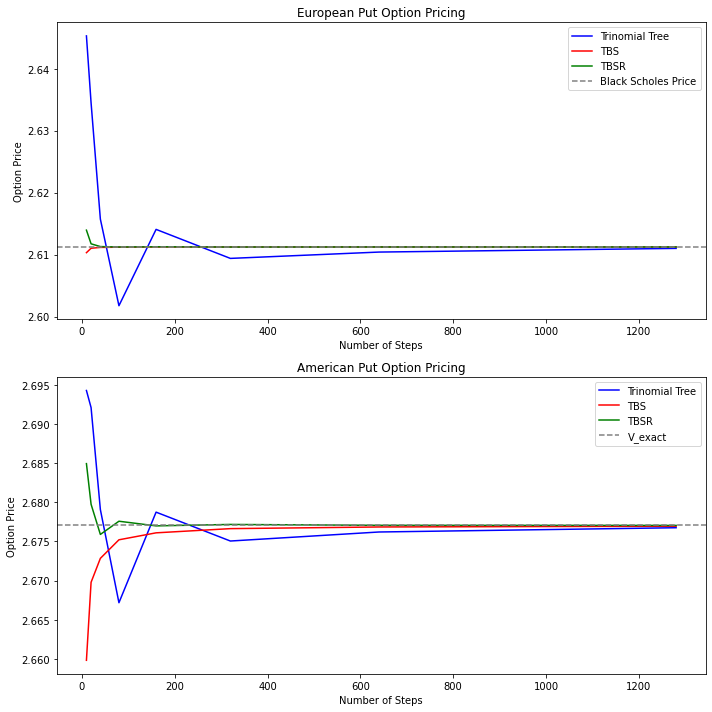

In [19]:
## Plotting Results ##
fig, ax = plt.subplots(2, 1, figsize=(10, 10))

# European Put Option Pricing Plot
ax[0].plot(N, EP_TT, label="Trinomial Tree", color='blue')
ax[0].plot(N, EP_TBS, label="TBS", color='red')
ax[0].plot(N, EP_TBSR, label='TBSR', color='green')
ax[0].axhline(y=bs_price, color='grey', linestyle='--', label="Black Scholes Price")
ax[0].set_title("European Put Option Pricing")
ax[0].set_xlabel("Number of Steps")
ax[0].set_ylabel("Option Price")
ax[0].legend()

# American Put Option Pricing Plot
ax[1].plot(N, AP_TT, label="Trinomial Tree", color='blue')
ax[1].plot(N, AP_TBS, label="TBS", color='red')
ax[1].plot(N, AP_TBSR, label='TBSR', color='green')
ax[1].axhline(y=V_exact, color='grey', linestyle='--', label="V_exact")
ax[1].set_title("American Put Option Pricing")
ax[1].set_xlabel("Number of Steps")
ax[1].set_ylabel("Option Price")
ax[1].legend()

plt.tight_layout()
plt.show()